## *Задание*
1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

2. Подберите параметры модели SARIMAX для этого ряда.

3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data_m = data.resample('M').mean()

C:\Users\alibe\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


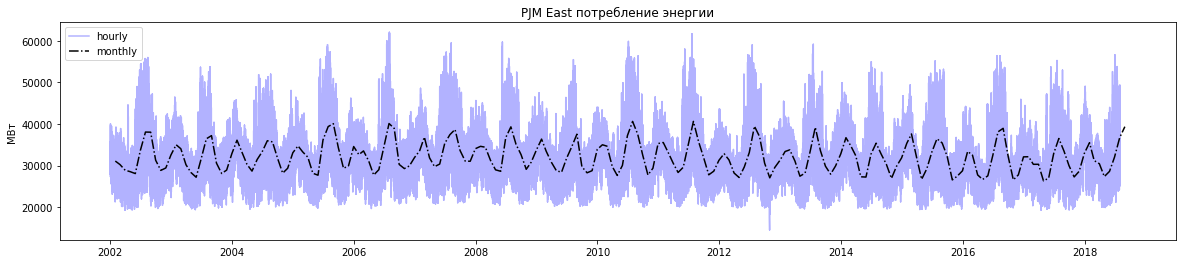

In [4]:
plt.figure(figsize =(20,4))
plt.plot(data.index, data['PJME_MW'].values, 'b', alpha =0.3, label='hourly')
plt.plot(data_m.index, data_m['PJME_MW'].values, '-.k', label='monthly')
plt.title('PJM East потребление энергии' )
plt.ylabel('МВт')
plt.legend()
plt.show()

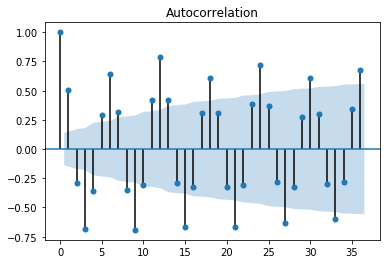

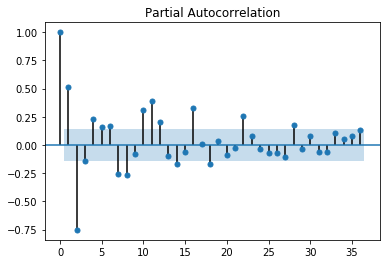

In [5]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=36)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=36)
plt.show()

In [6]:
import warnings

# Определим p, d и q 
q = 2
p = 1
d = 2
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
#будем работать с недельными данными, тогда сезонность это 12 месяцев
qs = 1
ps = 0
ds = 1
seasonal_pdq = [ps, ds, qs, 12] 

In [7]:
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-24],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[1, 2, 2]x[0, 1, 1, 12] - AIC:2640.6336788024637


In [8]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(1, 2, 2)x(0, 1, 1, 12)   Log Likelihood               -1315.317
Date:                            Thu, 23 Jan 2020   AIC                           2640.634
Time:                                    13:00:25   BIC                           2655.586
Sample:                                         0   HQIC                          2646.709
                                            - 176                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

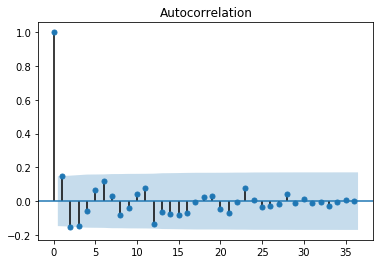

In [9]:
sm.graphics.tsa.plot_acf(results.resid, lags=36)
plt.show()

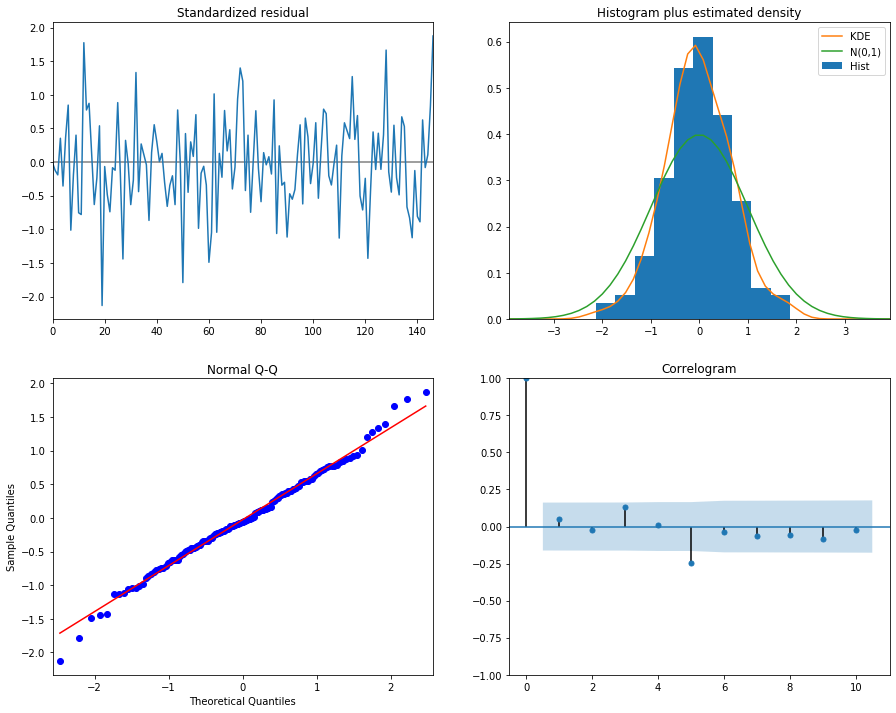

In [10]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [11]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [12]:
%%time
warnings.filterwarnings("ignore") # отключает предупреждения
best_aic = float('Inf')
best_pqd = None
best_seasonal_pqd = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-24],
                                    order=param,
                                    seasonal_order=param_seasonal,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            if results.aic < best_aic:
                best_pqd = param
                best_seasonal_pqd = param_seasonal
                best_aic = results.aic
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
print('best ARIMA{}x{} - best AIC:{}'.format(best_pqd, best_seasonal_pqd, best_aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:4134.131475716988
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:3741.798369699642
ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:3443.5660918410786
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:2934.763927613225
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:2711.2198161762562
ARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:2480.6699168055547
ARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:2870.1662178729175
ARIMA(0, 0, 0)x(0, 2, 1, 12) - AIC:2600.8866458075227
ARIMA(0, 0, 0)x(0, 2, 2, 12) - AIC:2358.1746030202753
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:2957.3964747452546
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:2936.7942994612067
ARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:2692.56604081519
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:2720.3768526623526
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:2703.365745693547
ARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:2476.3558716639454
ARIMA(0, 0, 0)x(1, 2, 0, 12) - AIC:2608.7447369812717
ARIMA(0, 0, 0)x(1, 2, 1, 12) - AIC:2579.867548504406
ARIMA(0, 0, 0)x(1, 2, 2, 12) - AIC:2348.616369667774
ARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:2

ARIMA(0, 1, 2)x(2, 0, 1, 12) - AIC:2670.8077612871293
ARIMA(0, 1, 2)x(2, 0, 2, 12) - AIC:2619.205050142644
ARIMA(0, 1, 2)x(2, 1, 0, 12) - AIC:2469.706796757502
ARIMA(0, 1, 2)x(2, 1, 1, 12) - AIC:2478.246311864751
ARIMA(0, 1, 2)x(2, 1, 2, 12) - AIC:2412.1079135792124
ARIMA(0, 1, 2)x(2, 2, 0, 12) - AIC:2330.051258462938
ARIMA(0, 1, 2)x(2, 2, 1, 12) - AIC:2289.5690932667303
ARIMA(0, 1, 2)x(2, 2, 2, 12) - AIC:2235.7314699634812
ARIMA(0, 2, 0)x(0, 0, 0, 12) - AIC:3365.6790605239403
ARIMA(0, 2, 0)x(0, 0, 1, 12) - AIC:3100.1995901093414
ARIMA(0, 2, 0)x(0, 0, 2, 12) - AIC:2866.5426171834292
ARIMA(0, 2, 0)x(0, 1, 0, 12) - AIC:3091.8145522806276
ARIMA(0, 2, 0)x(0, 1, 1, 12) - AIC:2820.8214326315783
ARIMA(0, 2, 0)x(0, 1, 2, 12) - AIC:2593.3289927241112
ARIMA(0, 2, 0)x(0, 2, 0, 12) - AIC:3031.025723707379
ARIMA(0, 2, 0)x(0, 2, 1, 12) - AIC:2695.797534911142
ARIMA(0, 2, 0)x(0, 2, 2, 12) - AIC:2431.038740479768
ARIMA(0, 2, 0)x(1, 0, 0, 12) - AIC:3078.4697698223226
ARIMA(0, 2, 0)x(1, 0, 1, 12) - AIC:

ARIMA(1, 0, 2)x(1, 0, 2, 12) - AIC:2719.606600229832
ARIMA(1, 0, 2)x(1, 1, 0, 12) - AIC:2682.048243974905
ARIMA(1, 0, 2)x(1, 1, 1, 12) - AIC:2644.2035016447276
ARIMA(1, 0, 2)x(1, 1, 2, 12) - AIC:2415.752752671713
ARIMA(1, 0, 2)x(1, 2, 0, 12) - AIC:2574.8235680762373
ARIMA(1, 0, 2)x(1, 2, 1, 12) - AIC:2521.53715939021
ARIMA(1, 0, 2)x(1, 2, 2, 12) - AIC:2286.4465398928387
ARIMA(1, 0, 2)x(2, 0, 0, 12) - AIC:2775.251027544875
ARIMA(1, 0, 2)x(2, 0, 1, 12) - AIC:2776.264493039456
ARIMA(1, 0, 2)x(2, 0, 2, 12) - AIC:2740.457923694385
ARIMA(1, 0, 2)x(2, 1, 0, 12) - AIC:2453.552900125909
ARIMA(1, 0, 2)x(2, 1, 1, 12) - AIC:2453.014203315319
ARIMA(1, 0, 2)x(2, 1, 2, 12) - AIC:2420.944628616162
ARIMA(1, 0, 2)x(2, 2, 0, 12) - AIC:2307.6013479823428
ARIMA(1, 0, 2)x(2, 2, 1, 12) - AIC:2309.100846362659
ARIMA(1, 0, 2)x(2, 2, 2, 12) - AIC:2298.6352224837756
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:3314.895477502297
ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:3031.8624530704474
ARIMA(1, 1, 0)x(0, 0, 2, 12) - AIC:2784.1

ARIMA(1, 2, 2)x(0, 1, 1, 12) - AIC:2640.6336788024637
ARIMA(1, 2, 2)x(0, 1, 2, 12) - AIC:2428.3775076718152
ARIMA(1, 2, 2)x(0, 2, 0, 12) - AIC:2850.266332223243
ARIMA(1, 2, 2)x(0, 2, 1, 12) - AIC:2552.3247164208037
ARIMA(1, 2, 2)x(0, 2, 2, 12) - AIC:2315.3343356365463
ARIMA(1, 2, 2)x(1, 0, 0, 12) - AIC:2940.105058786359
ARIMA(1, 2, 2)x(1, 0, 1, 12) - AIC:2896.8318507019435
ARIMA(1, 2, 2)x(1, 0, 2, 12) - AIC:2673.870165517743
ARIMA(1, 2, 2)x(1, 1, 0, 12) - AIC:2692.2444527704547
ARIMA(1, 2, 2)x(1, 1, 1, 12) - AIC:2640.8790629948617
ARIMA(1, 2, 2)x(1, 1, 2, 12) - AIC:2430.1273483459854
ARIMA(1, 2, 2)x(1, 2, 0, 12) - AIC:2613.4669961655572
ARIMA(1, 2, 2)x(1, 2, 1, 12) - AIC:2473.6823663421983
ARIMA(1, 2, 2)x(1, 2, 2, 12) - AIC:2316.844058134961
ARIMA(1, 2, 2)x(2, 0, 0, 12) - AIC:2714.330446722993
ARIMA(1, 2, 2)x(2, 0, 1, 12) - AIC:2710.296517516993
ARIMA(1, 2, 2)x(2, 0, 2, 12) - AIC:2674.3864926134124
ARIMA(1, 2, 2)x(2, 1, 0, 12) - AIC:2472.014256125949
ARIMA(1, 2, 2)x(2, 1, 1, 12) - AIC:

ARIMA(2, 1, 1)x(2, 1, 2, 12) - AIC:2430.349712943913
ARIMA(2, 1, 1)x(2, 2, 0, 12) - AIC:2294.6654884271734
ARIMA(2, 1, 1)x(2, 2, 1, 12) - AIC:2252.566313695895
ARIMA(2, 1, 1)x(2, 2, 2, 12) - AIC:2266.9856210177254
ARIMA(2, 1, 2)x(0, 0, 0, 12) - AIC:3108.6045112428287
ARIMA(2, 1, 2)x(0, 0, 1, 12) - AIC:2859.3674784716873
ARIMA(2, 1, 2)x(0, 0, 2, 12) - AIC:2649.9029743812994
ARIMA(2, 1, 2)x(0, 1, 0, 12) - AIC:2888.038234240483
ARIMA(2, 1, 2)x(0, 1, 1, 12) - AIC:2622.059287501699
ARIMA(2, 1, 2)x(0, 1, 2, 12) - AIC:2411.7686442077434
ARIMA(2, 1, 2)x(0, 2, 0, 12) - AIC:2829.38088953857
ARIMA(2, 1, 2)x(0, 2, 1, 12) - AIC:2488.076515764386
ARIMA(2, 1, 2)x(0, 2, 2, 12) - AIC:2227.1032428495037
ARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:2874.836346612393
ARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:2843.6911302390536
ARIMA(2, 1, 2)x(1, 0, 2, 12) - AIC:2631.808396477396
ARIMA(2, 1, 2)x(1, 1, 0, 12) - AIC:2669.2903562834235
ARIMA(2, 1, 2)x(1, 1, 1, 12) - AIC:2633.942564482091
ARIMA(2, 1, 2)x(1, 1, 2, 12) - AIC:241

In [14]:
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-24],order=best_pqd,
                                seasonal_order=best_seasonal_pqd,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 2225.930299177341


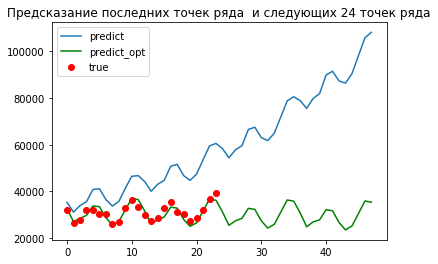

In [17]:
pred_dynamic = results.forecast(48)    #делаем предсказание на 24 точки от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(48)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-24:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 24 точек ряда')
plt.legend()

plt.show()

Модель на недельных данных показывает меньший AIC, больше похожа на реальные данные.